# Week7 - Decision Tree Lab & HW

## LAB

* Do a quick EDA to understand your data and explain what you need for your pipeline.
* Explain what metric would be appropriate for this task (1 sentence).
* Explain your game plan
* Create a preprocessing pipeline (without the model).


## HW

* Train-test split
* Create 2 new pipelines for the following 2 models and use preprocessing pipeline you created in the previous step
    * a decison tree model https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    * a random forest model https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* Define params for GridSearchCV for both models
* Evaluate the models

* Explain findings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
# DON'T CHANGE ANYTHING HERE....

random.seed(42)
def remove_values(df, cols, perc=0.001):
    for i in cols:
        mask = pd.Series(random.choices([0,1], weights=[perc, 1-perc], k=len(df[i])))
        df[i] = [ x if i==1 else None for x, i in zip(df[i], mask)]

def create_df(size=1000000):
    from sklearn.datasets import make_classification

    X, y = make_classification(
        n_samples=size,
        n_features=5,
        n_informative=5,
        n_redundant=0,
        n_classes=2,
        flip_y=0.2,
        random_state=4
    )
    
    df = pd.DataFrame(X)
    df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    df.f1 = df.f1**2
    df.f2 = df.f2**2
    df.f3 = df.f3*1000
    
    flag = random.choices([True, False], weights=[0.65, 0.35], k=len(y))
    f6 = ['A' if i == 0 else 'B' for i in y]
    
    f6 = [f if i else ('B' if f=='A' else 'A') for i,f in zip(flag, f6)]
    df['f6'] = f6
    
    remove_values(df, df.columns, perc=0.05)
    
    return df, pd.Series(y)
    
X, y = create_df()

In [3]:
# eda code

In [4]:
X.describe()

,f1,f2,f3,f4,f5
count,9.499330e+05,9.498840e+05,949804.000000,950444.000000,950149.000000
mean,2.970269e+00,2.698242e+00,1.203865,-0.002337,-0.000394
std,4.223559e+00,3.863111e+00,1441.308642,1.682211,1.683646
min,7.464873e-15,4.200556e-12,-6319.721066,-8.364699,-7.067953
25%,3.265102e-01,3.144912e-01,-1077.181298,-1.172712,-1.186616
50%,1.415231e+00,1.310581e+00,-403.563631,0.067817,0.001923
75%,3.905995e+00,3.501739e+00,1009.950057,1.156616,1.152483
max,9.069379e+01,8.512300e+01,7402.596849,9.717087,8.354947


<Axes: >

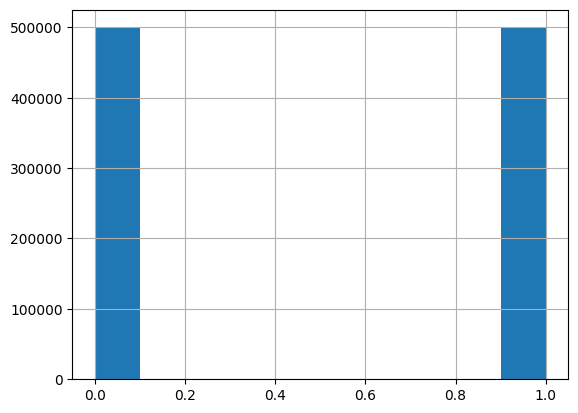

In [5]:
y.hist()

In [6]:
X.isna().sum()

f1    50067
f2    50116
f3    50196
f4    49556
f5    49851
f6    50017
dtype: int64

In [7]:
X.head(5)

,f1,f2,f3,f4,f5,f6
0,3.083178,3.022878,1276.390696,-2.672085,1.085629,B
1,NaN,1.764094,-873.709051,2.084035,0.387268,A
2,8.663599,NaN,-563.461158,-0.044922,2.512673,A
3,NaN,3.899908,753.129656,1.565944,-3.771516,A
4,0.684772,22.623978,-392.739840,-0.136113,-2.028027,A


The data here shows we have one million rows, and six columns. Each feature has approximately 50,000 values missing from it. Features 1 through 5 have numerical values while feature six has categorical values. Feature 3 also has much larger numbers and more variation than features 1, 2, or 4. Beacause the data is balanced, the most appropriate metric for model evaluation would be accuracy.

The gameplan will be to take 10,000 rows of data to compare models and find ideal hyperparameters. We will take these 10,000 rows, run them through the processing pipeline, and use them along with a small set of hyperparameters so that this step is not too costly. From there, the hyperparameters with the best scores will be taken. We will then compare the performance of a decision tree model and a random forest model. Whichever model performs better will then be used with the real train-test split and the best known hyperparameters. If there is a tie between the scores of two models, the simpler model will be used.

In [8]:
# create processing pipeline
num_vars = ['f1', 'f2', 'f3', 'f4', 'f5']
cat_vars = ['f6']

X_sub = X[0:10000]
y_sub = y[0:10000]

In [9]:
num_pipeline = Pipeline([
    ('imputing', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaling', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputing', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoding', OneHotEncoder())
])

processing_pipeline = ColumnTransformer(transformers=[
    ('num pipeline', num_pipeline, num_vars),
    ('cat pipeline', cat_pipeline, cat_vars)
])

processing_pipeline

ColumnTransformer(transformers=[('num pipeline',
                                 Pipeline(steps=[('imputing', SimpleImputer()),
                                                 ('scaling',
                                                  StandardScaler())]),
                                 ['f1', 'f2', 'f3', 'f4', 'f5']),
                                ('cat pipeline',
                                 Pipeline(steps=[('imputing',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoding',
                                                  OneHotEncoder())]),
                                 ['f6'])])

## HW

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, random_state=1000, test_size=0.2)

In [14]:
dt_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('dt', DecisionTreeClassifier())]
)
dt_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num pipeline',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat pipeline',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OneHotEncoder())]),
                                                  ['f6'])])),
                ('dt', DecisionTreeClassifier())])

In [46]:
dt_param_grid = [
    {
        'dt__max_depth': [8, 9, 10],
        'dt__min_samples_leaf': [15, 16, 17]
    }
]

scoring ='accuracy'

dt_gc = GridSearchCV(estimator=dt_modeling_pipeline, param_grid=dt_param_grid, cv=5, scoring=scoring)
dt_gcv_results = dt_gc.fit(X_train, y_train)

In [47]:
dt_gcv_results.best_params_

{'dt__max_depth': 9, 'dt__min_samples_leaf': 16}

In [48]:
dt_gcv_results.score(X_train, y_train)

0.837

In [49]:
dt_gcv_results.score(X_test, y_test)

0.7915

It looks like the best hyperparameters found were a max depth of 9 and a minimum number of samples per leaf of 16. This led to an accuracy score of 83.7% on the training data and 79.15% on the testing data. These hyperparameters were found by incrementally increasing them until a local maximum in accuracy was found.

In [50]:
rf_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('rf', RandomForestClassifier())]
)
rf_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num pipeline',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat pipeline',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OneHotEncoder())]),
                                                  ['f6'])])),
                ('rf', RandomForestClassifier())])

In [60]:
rf_param_grid = [
    {
        'rf__max_depth': [14, 15, 16],
        'rf__min_samples_leaf': [7, 8, 9]
    }
]

scoring = 'accuracy'

rf_gc = GridSearchCV(estimator=rf_modeling_pipeline, param_grid=rf_param_grid, cv=5, scoring=scoring)
rf_gcv_results = rf_gc.fit(X_train, y_train)

In [61]:
rf_gcv_results.best_params_

{'rf__max_depth': 15, 'rf__min_samples_leaf': 8}

In [62]:
rf_gcv_results.score(X_train, y_train)

0.869375

In [63]:
rf_gcv_results.score(X_test, y_test)

0.812

It looks like the best hyperparameters for the random forest model are 15 for max depth and 8 for minimum samples per leaf. These were found after trying with a set of [10, 20, 30] and narrowing down to [14, 15, 16] for max_depth and the same for min_samples_leaf, except narrowing down to [7, 8, 9]

I would go with the random forest model because is has better accuracy on both the training and testing data, when compared to the decision tree model.

In [64]:
# create a new pipeline with the winner model and the best params
# evaluate the same results

#New train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1000, test_size=0.2)

#New pipeline
num_pipeline = Pipeline([
    ('imputing', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaling', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputing', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoding', OneHotEncoder())
])

processing_pipeline = ColumnTransformer(transformers=[
    ('num pipeline', num_pipeline, num_vars),
    ('cat pipeline', cat_pipeline, cat_vars)
])

#Chosen model with best hyperparameters
rf_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('rf', RandomForestClassifier(max_depth=15, min_samples_leaf=8))]
)
rf_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num pipeline',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat pipeline',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OneHotEncoder())]),
                                                  ['f6'])])),
                ('rf',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=8))])

In [65]:
rf_model = rf_modeling_pipeline.fit(X_train, y_train)

In [66]:
y_hat = rf_model.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     99690
           1       0.84      0.84      0.84    100310

    accuracy                           0.84    200000
   macro avg       0.84      0.84      0.84    200000
weighted avg       0.84      0.84      0.84    200000



It looks like this model had an accuracy of 84% on the testing data which is not bad. The precision and recall were exactly the same, probably becasue the dataset was very balanced, and because there were approximately 500,000 points for each, making any differences not noticeable. Overall, this model presents itself as a good candidate for deployment on data with the given features in the training and test data.